In [1]:
import numpy as np
import re
from os import listdir
from os.path import isfile, join#
from collections import OrderedDict
from itertools import product, groupby
import itertools

In [2]:
def get_step_1_params(line):
    return [int(line[0]), int(line[1]), line[1], line[1], line[2]]       
def get_step_2_params(line):
    return [int(line[0]), int(line[1]), line[3]]
def get_step_3_params(line):
    return [int(line[0]), int(line[1]), line[3], line[4]]

array([ 0.01306942, -1.1468987 ])

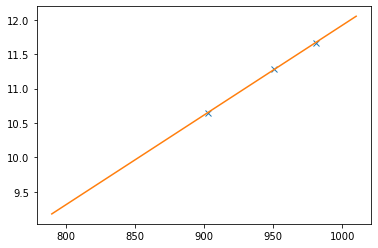

In [3]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def linear(x, a, b):
    return a*x+b

def heat_flux_linear(T_end):
    return 11.28*T_end/950

ref_temp = [902.61, 950.90, 980.64]
bhf = [10.65, 11.28, 11.67]

params, cov = curve_fit(linear, ref_temp, bhf)
xx = np.linspace(790, 1010, 1000)
plt.plot(ref_temp, bhf, 'x')
plt.plot(xx, linear(xx, *params))

params

In [4]:

def format_step_1(params):
    #read template STEP 1
    with open('FEM_Template/Step1_template.inp') as f:
        step1_lines = f.readlines()
    step1_lines[4]=step1_lines[4].format(params[0], params[1])
    step1_lines[3590]=step1_lines[3590].format(params[2])
    step1_lines[3596]=step1_lines[3596].format(params[3])
    step1_lines[3631]=step1_lines[3631].format(params[4])

    outfile = open('FEM_Template/inp/step1/WTP-M1_WS{}_WZ{}.inp'.format(params[0], params[1]), 'w')
    outfile.writelines(step1_lines)
    outfile.close()


In [5]:
def format_step_2(params_step2):
    with open('FEM_Template/Step2_template.inp') as g:
        step2_lines = g.readlines()
    step2_lines[4]=step2_lines[4].format(params_step2[0], params_step2[1], params_step2[2] )
    step2_lines[15]=step2_lines[15].format(params_step2[0], params_step2[1])
    step2_lines[23]=step2_lines[23].format(params_step2[0], params_step2[1])
    step2_lines[31]=step2_lines[31].format(params_step2[0], params_step2[1])
    step2_lines[4078]=step2_lines[4078].format(params_step2[2])

    outfile = open('FEM_Template/inp/step2/WTP-M2_WS{}_WZ{}_p{}.inp'.format(params_step2[0], params_step2[1], params_step2[2]), 'w')
    outfile.writelines(step2_lines)
    outfile.close()


In [6]:
def format_step_3(params_step3):
    with open('FEM_Template/Step3_template.inp') as h:
        step3_lines = h.readlines()
    step3_lines[4]=step3_lines[4].format(params_step3[0], params_step3[1], params_step3[2], params_step3[3] )
    step3_lines[15]=step3_lines[15].format(params_step3[0], params_step3[1], params_step3[2])
    step3_lines[23]=step3_lines[23].format(params_step3[0], params_step3[1], params_step3[2])
    step3_lines[31]=step3_lines[31].format(params_step3[0], params_step3[1], params_step3[2])
    step3_lines[535]=step3_lines[535].format(params_step3[2])
    step3_lines[562]=step3_lines[562].format(params_step3[3]-0.1)

    outfile = open('FEM_Template/inp/step3/WTP-M3_WS{}_WZ{}_p{}_t{}.inp'.format(params_step3[0], params_step3[1], params_step3[2], params_step3[3]), 'w')
    outfile.writelines(step3_lines)
    outfile.close()


In [7]:
parameter_grid = OrderedDict([
    ('oven_temps', np.linspace(800, 1000, 21)), # 10 deg steps
    ('vorlauf_temps', np.linspace(60, 170, 12)), #10 deg steps
    ('heat_fluxes', linear(np.linspace(800, 1000, 21), *params)), # get the actual corresponding heat fluxes
    ('press_forces', np.linspace(10, 25, 16)), # many do we want?
    ('press_holding', np.linspace(4, 10, 4))
])
grid = np.array([parameters for parameters in product(*parameter_grid.values())])
grid.shape

# format in the values like: WS Temp, WZ Temp, WZ Temp STempel, WZ Temp Boden, Heat Flux (WS Temp)

# params = [950,90,90.0,90.0, 11.28]
params = np.unique([get_step_1_params(line) for line in grid], axis=0)
print(params.shape)
for param_set in params:
    format_step_1(param_set)    
    
#params_step2 = [950,90,19.0]
params_step2 = np.unique([get_step_2_params(line) for line in grid], axis=0) 
#params_step2 = np.array([get_step_2_params(line) for line in grid])
print(params_step2.shape)
for param_set in params_step2:
    format_step_2(param_set)
    
#params_step3 = [950,90,19.0,10]
params_step3 = np.unique([get_step_3_params(line) for line in grid], axis=0)
print(params_step3.shape)
for param_set in params_step3:
    format_step_3(param_set)

(5292, 5)
(4032, 3)
(16128, 4)


In [8]:
def write_bat(filepath, step):
    onlyfiles = [f[:-4] for f in listdir(filepath) if isfile(join(filepath, f))]
    with open("batchfiles/jobfile_step_{}.bat".format(step), "a") as file_object:
        for filename in onlyfiles:
            string = 'call abaqus job={} cpus=4 background \n'.format(filename)
            file_object.write(string)

In [9]:
write_bat('FEM_Template/inp/step1',1)
write_bat('FEM_Template/inp/step2',2)
write_bat('FEM_Template/inp/step3',3)

In [10]:
def split_bat(filename, step, split):
    with open(filename) as file:
        lines = file.readlines()    
    split = np.array_split(lines, split)
    for i, chunk in enumerate(split):
        with open("batchfiles/jobfile_step_{}_part_{}.bat".format(step, i), "a") as file_object:
            for line in chunk:
                file_object.write(line)
        #print(chunk)
        #np.savetxt("batchfiles/jobfile_step_{}_part_{}.bat".format(step, i), chunk, newline='\n')

In [11]:
split_bat("batchfiles/jobfile_step_1.bat", 1, 8)
split_bat("batchfiles/jobfile_step_2.bat", 2, 8)
split_bat("batchfiles/jobfile_step_3.bat", 3, 8)